## MULTILAYER PERCEPTRON MODEL WITH RUL LIMITATION
This notebook presents de coding to build the Multilayer Perceptron Model with the RUL limition and the implementation over FD003.

In [1]:
## Load basic libraries

from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 
import random
random.seed(123)

#model_path = 'MLP_regression_PCA_FD3_tuned.h5'




In [2]:
## Load data science libraries

import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import keras.backend as Kback
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from math import e
from Perform_function import perform_func




Using TensorFlow backend.


In [3]:
## Data loading

train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD003.txt", delimiter = ' ')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD003.txt", delimiter = ' ')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD003.txt")
RUL_real = RUL_test

In [4]:
#######
#Data ingestion & processing
######

#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for both sensor variables

train_df['Cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_df[cols_normalize])
norm_train_df = pd.DataFrame(scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# Principal Component Analysis Dimensionality Reduction

pca = PCA(.95)

pca.fit(norm_train_df)
transformed_train = pca.transform(scaled_train)

df_transformed_train = pd.DataFrame(transformed_train, index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(df_transformed_train)
train_df = join_df.reindex()


# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']




In [5]:
###TEST DATA SET###


# Standardization for sensor variables
test_df['Cycle_norm'] = test_df['Cycle']
norm_test_df = pd.DataFrame(scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

print(norm_train_df.shape,norm_test_df.shape)

#Principal Component Analysis Dimensionality Reduction

transformed_test = pca.transform(norm_test_df)

df_transformed_test = pd.DataFrame(transformed_test, index = test_df.index)

join_df = test_df[test_df.columns.difference(cols_normalize)].join(df_transformed_test)
test_df = join_df.reindex()

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)



(24720, 25) (16596, 25)


In [28]:
## Model dataset preparation

train_cols = list(train_df.columns[2:-2].values)

train_all = train_df[train_cols]

train = train_df
X_train = train[train_cols].to_numpy()
Y_train = train['RUL'].to_numpy()
Y_tuned = np.zeros(len(Y_train))
Y_tuned[:] = Y_train
Y_tuned[Y_tuned>150]=150

#train_valid = train_df[train_df['Unit']<=2]

#X_valid = train_valid[train_cols].to_numpy()
#Y_valid = train_valid['RUL'].to_numpy()


test_proof = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
                for id in test_df['Unit'].unique()]).reset_index(drop = True)


test_proof.drop(['max'], axis = 1, inplace = True)





In [9]:
## Hyperparameters

# Here the hyperparameters of the model are defined
n_neurons_first = 30 # Number of neurons in the input layer
n_neurons_hidden = 30 # Number of neurons in the hidden layer
n_hidden_layers = 5 # Number of layers

dim = X_train.shape[1]


In [10]:
#Additional metrics to be implemented in the model

def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    for i in d: 
        if i<0:
            score += (e**(-i/a1) - 1)
        else : 
            score += (e**(i/a2) - 1)
    return score


In [11]:
## Model building

# The Multilayer Perceptron Model is built according to the hyperparameters configuration 


model_MLP = Sequential()

model_MLP.add(Dense(
    n_neurons_first, 
    input_dim = dim,
    kernel_initializer = 'glorot_normal', 
    activation = 'relu'))
model_MLP.add(Dropout(0.2))

for i in range(n_hidden_layers):
    model_MLP.add(Dense(n_neurons_hidden, kernel_initializer = 'glorot_normal', activation = 'relu'))
    model_MLP.add(Dropout(0.2))

model_MLP.add(Dense(1, kernel_initializer = 'glorot_normal'))

model_MLP.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mae', r2_keras] )

print(model_MLP.summary())

result = model_MLP.fit(X_train, Y_tuned, epochs = 100, batch_size = 5, verbose = 1, 
    validation_split = 0.05, 
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)])
        
print(result.history.keys())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                360       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)               

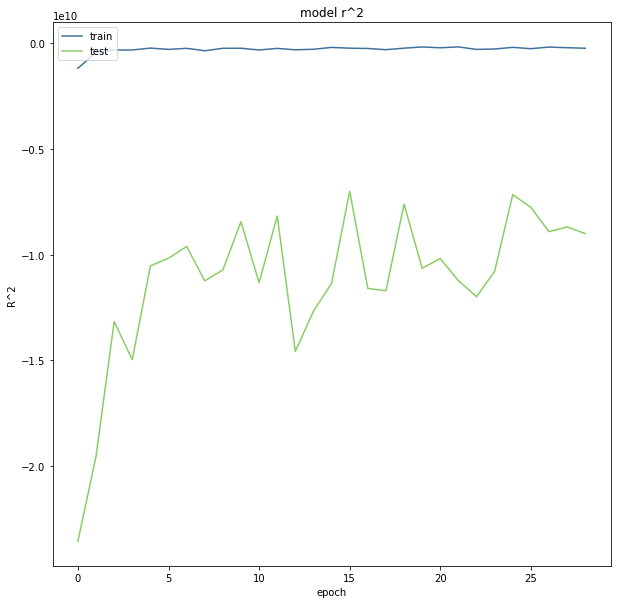

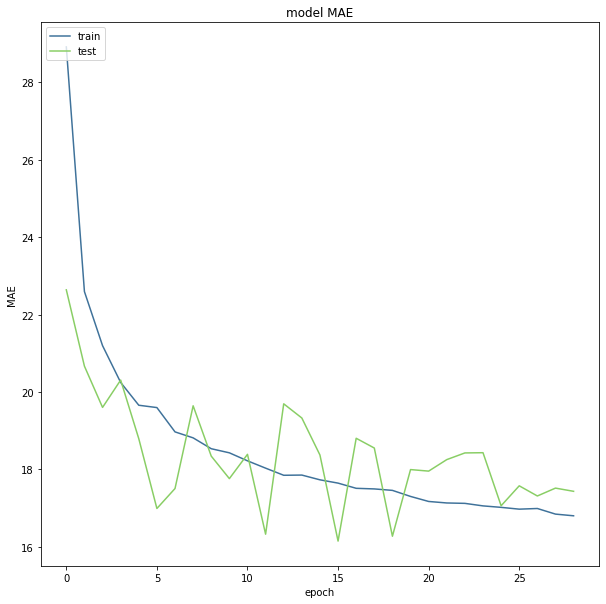

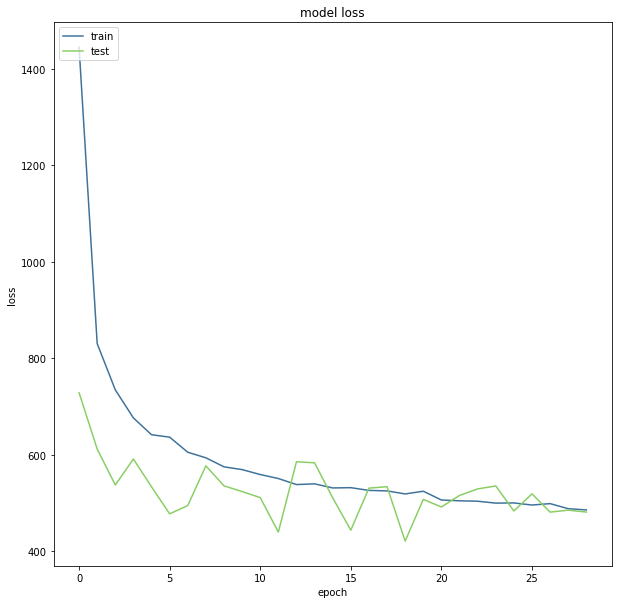

In [12]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")

In [13]:
predictions = model_MLP.predict(train_all)

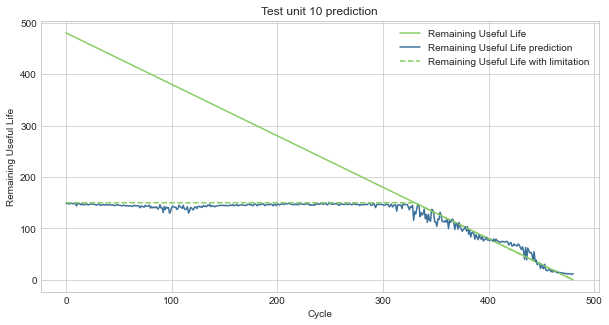

In [29]:
## Model predictions for the test set

train_df['RUL_predict'] = predictions

unit = 10

plt.style.use('seaborn-whitegrid')

fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")
ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 10 prediction")

ax.legend()




MAE: 17.632976531982422

R^2: 0.7393436431884766
[[ 52.767647]
 [ 90.8999  ]
 [ 32.190678]
 [128.55084 ]
 [136.07684 ]
 [119.39539 ]
 [ 79.703255]
 [ 80.819214]
 [ 84.09859 ]
 [104.00144 ]
 [ 74.271996]
 [ 89.17349 ]
 [121.66479 ]
 [ 36.614872]
 [127.78465 ]
 [114.88866 ]
 [117.80956 ]
 [139.00705 ]
 [117.765495]
 [ 90.73094 ]
 [ 26.855894]
 [128.78    ]
 [ 85.19367 ]
 [ 18.52161 ]
 [ 77.045364]
 [ 19.943583]
 [133.25717 ]
 [117.57809 ]
 [112.61343 ]
 [ 89.04613 ]
 [ 82.61182 ]
 [ 41.533287]
 [ 85.15066 ]
 [ 88.23063 ]
 [119.979454]
 [140.95459 ]
 [143.67188 ]
 [ 37.412727]
 [ 19.95895 ]
 [ 45.95632 ]
 [138.00002 ]
 [ 96.84791 ]
 [116.19329 ]
 [ 64.60688 ]
 [131.59023 ]
 [ 11.996464]
 [134.82494 ]
 [ 69.0193  ]
 [145.18628 ]
 [ 19.371084]
 [ 96.84591 ]
 [143.02419 ]
 [103.09821 ]
 [141.78441 ]
 [ 54.783783]
 [ 80.36641 ]
 [ 83.64728 ]
 [ 84.372574]
 [ 52.250725]
 [ 96.755806]
 [141.03554 ]
 [ 91.08569 ]
 [133.38773 ]
 [ 37.420082]
 [131.47878 ]
 [ 96.815926]
 [ 95.332436]
 [135.85866 

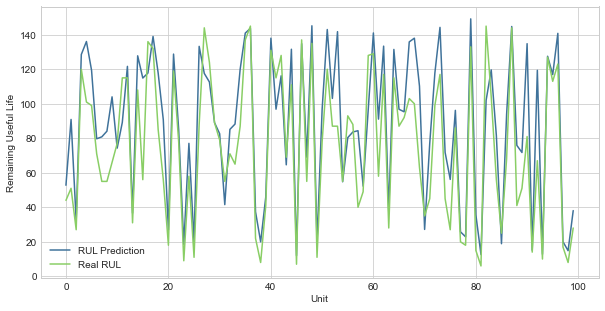

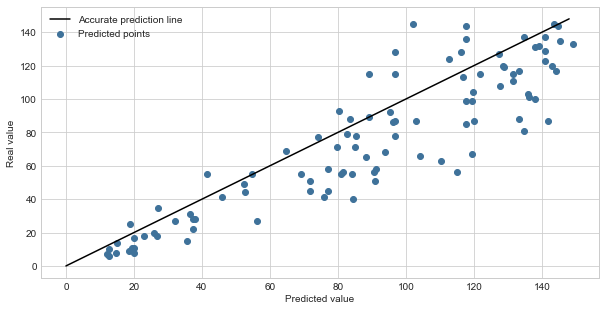

In [15]:
## Model evaluation - Part 1

if os.path.isfile(model_path):
    
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(test_proof.iloc[:,2:-1], test_proof['RUL'].to_numpy(), verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(test_proof.iloc[:,2:-1])
    y_true_test = test_proof['RUL'].to_numpy()

    print(y_pred_test)
    print(y_true_test)

    #test_set = pd.DataFrame(y_pred_test)
    #test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="#3f729a")
    plt.plot(y_true_test, color="#89ce65")
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('Unit')
    plt.legend(['RUL Prediction', 'Real RUL'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()


In [16]:
## Challenge score analysis

Computed_Score(y_true_test, y_pred_test[:,0])

806.5860531344512

The model score is: 806.5860531344512
The model accuracy is: 44.0
The model MAE is: 17.632977180480957
The model MSE is : 510.5140364458745
The model Mean Absolute Percentage Error (MAPE) is: 22.90806912012596
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 6.241407146714607


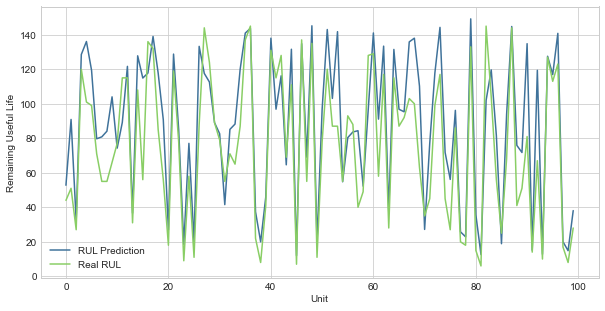

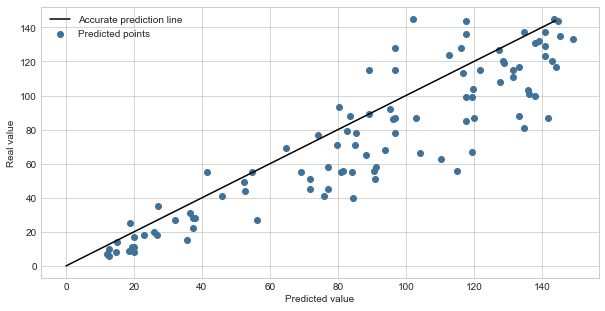

(806.5860531344512,
 44.0,
 17.632977180480957,
 510.5140364458745,
 22.90806912012596,
 6.241407146714607)

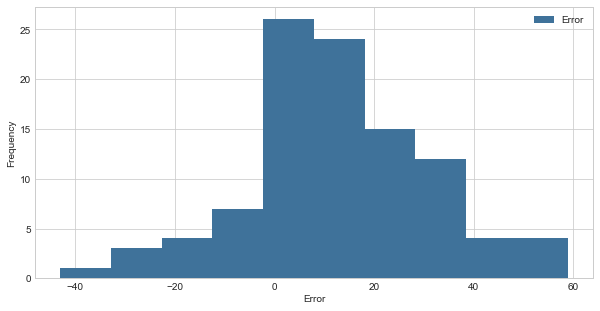

In [17]:
## Model evaluation - Part 2

perform_func(y_pred_test[:,0], y_true_test, test_df.groupby('Unit').max()['max'].to_numpy())

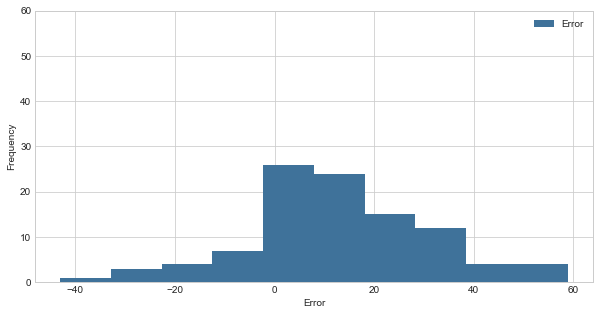

In [26]:
fig_hist = plt.figure(figsize=(10,5))
plt.hist(y_pred_test[:,0] - y_true_test, color = "#3f729a" )
plt.ylabel("Frequency")
plt.xlabel("Error")
plt.ylim(0,60)
plt.legend(['Error'])


In [18]:
## Error analysis by differencing the RUL to predict and the information we have about the turbine

error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_proof[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test[:,0] - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] > 140) , 'Group_RUL'] = 8


In [19]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped

,Unit,Cycle,RUL,error,Group_RUL
Group,,,,,
2,52.000000,38.000000,120.000000,23.024185,6.000000
3,63.400000,50.000000,118.800000,22.574228,6.600000
4,41.875000,71.000000,117.875000,16.677879,6.250000
5,57.000000,88.285714,115.142857,19.322520,6.285714
6,46.187500,111.750000,84.812500,23.864968,4.625000
7,29.888889,130.444444,71.000000,26.025946,4.111111
8,54.425926,225.185185,56.907407,13.752754,3.296296


In [20]:
error_grouped_RUL

,Unit,Cycle,RUL,error,Group
Group_RUL,,,,,
1,64.928571,240.928571,12.285714,7.454189,7.928571
2,56.666667,210.444444,29.222222,14.798284,7.666667
3,43.777778,185.777778,51.444444,23.629587,7.555556
4,41.166667,163.166667,71.000000,20.516258,7.166667
5,52.000000,146.466667,89.866667,23.547383,6.333333
6,44.000000,117.800000,112.866667,18.663677,5.466667
7,51.769231,133.615385,130.769231,11.500161,6.000000
8,59.000000,81.500000,144.500000,17.889715,4.500000


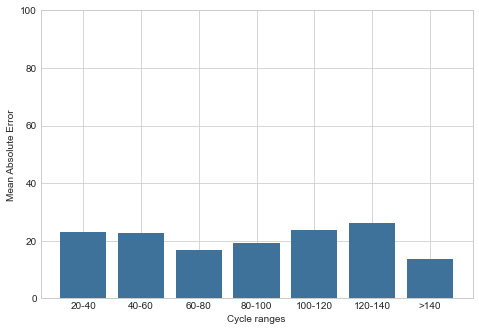

In [21]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,100)
plt.show()


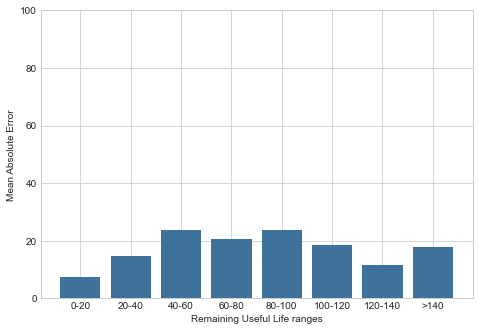

In [22]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,100)
plt.show()
